In [29]:
import pandas as pd 
import numpy as np
from bertopic import BERTopic
import re
import string
from nltk.tokenize import TweetTokenizer
import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [30]:
#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

In [31]:
df = pd.read_csv('df_for_topic_modelling.csv', index_col=[0])

In [3]:
df

,username,lang,text,created_at
0,abbgroupnews,en,New ABB E-mobility home charging solution help...,2023-01-03T15:18:41.000Z
1,abbgroupnews,en,ABB #technology to facilitate #energyefficienc...,2023-01-10T09:57:29.000Z
2,abbgroupnews,en,Better decisions for a greener data center! Ho...,2023-01-11T10:01:06.000Z
3,abbgroupnews,en,ABB Formula E Season 9 goes green in Mexico!\n...,2023-01-12T09:09:45.000Z
4,abbgroupnews,en,The #ABB Decoded #podcast with Frank Muehlon i...,2023-01-13T09:41:43.000Z
...,...,...,...,...
6125,vestas,en,🌎: 2023 was the hottest year in recorded histo...,2023-12-13T16:03:45.000Z
6126,vestas,en,"🇪🇺: To deliver clean, affordable, and secure e...",2023-12-19T15:32:30.000Z
6127,vestas,en,🌎 /🇬🇧 : In the making: one of the largest offs...,2023-12-20T15:13:16.000Z
6128,vestas,en,🌎/🇬🇧: Partnering with @RWE_AG to take the Nor...,2023-12-22T11:16:00.000Z


In [6]:
# Remove texts that are just URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))

# Remove texts that are just mentions, hashtags, or cashtags
df['text'] = df['text'].apply(lambda x: re.sub(r'(^|\s)@[^\s]+|(^|\s)#[^\s]+|(^|\s)\$[^\s]+', '', x))

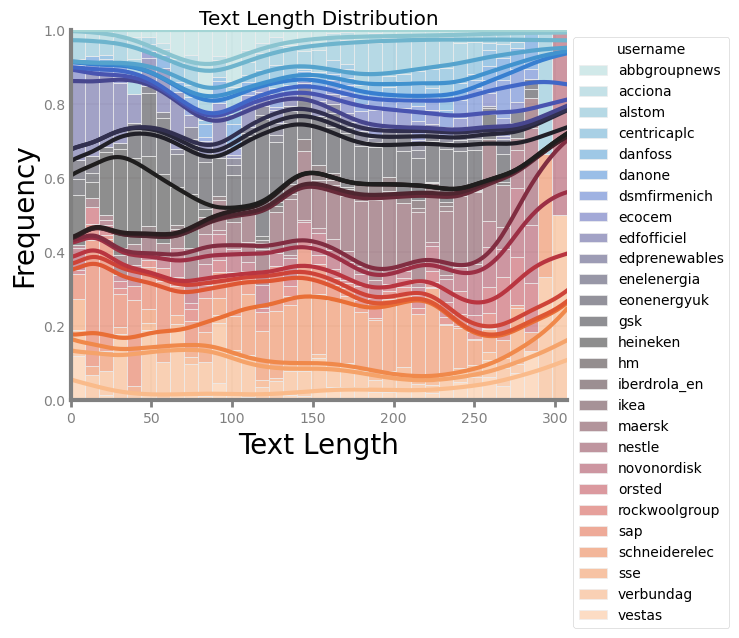

In [25]:
import seaborn as sns

sns.set_palette("icefire", n_colors = len(df.username.unique()))

# Calculate text lengths
df['text_length'] = df['text'].apply(len)

# Plot histogram
ax = sns.histplot(data = df, x = df['text_length'], hue = 'username', multiple='fill', kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [28]:
import pandas as pd
import re
import string
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Remove texts that are just URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))

# Remove texts that are just mentions, hashtags, or cashtags
df['text'] = df['text'].apply(lambda x: re.sub(r'(^|\s)@[^\s]+|(^|\s)#[^\s]+|(^|\s)\$[^\s]+', '', x))

# Filter texts based on length (e.g., keeping texts with more than 10 characters)
min_text_length = 0
df = df[df['text'].apply(len) >= min_text_length]

# Text preprocessing
# Lowercasing
df['text'] = df['text'].str.lower()

In [27]:
df.lang.unique()

array(['en', 'es', 'qme', 'art', 'fr', 'cs', 'zxx', 'da', 'tl', 'pl',
       'ca', 'und', 'it', 'tr', 'pt', 'ar', 'qam', 'in', 'qht', 'fi',
       'ht', 'cy', 'de'], dtype=object)

In [116]:
model = BERTopic(verbose=True)
 
#convert to list 
docs = df.text.to_list()
 
topics, probabilities = model.fit_transform(docs)

2024-04-22 02:33:53,470 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/188 [00:00<?, ?it/s]

2024-04-22 02:34:22,254 - BERTopic - Embedding - Completed ✓
2024-04-22 02:34:22,255 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-22 02:34:29,315 - BERTopic - Dimensionality - Completed ✓
2024-04-22 02:34:29,317 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-22 02:34:29,600 - BERTopic - Cluster - Completed ✓
2024-04-22 02:34:29,608 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-22 02:34:29,923 - BERTopic - Representation - Completed ✓


In [117]:
model.visualize_topics()

In [130]:
model.visualize_barchart(top_n_topics = 20, n_words = 10)

In [119]:
model.visualize_heatmap()

In [132]:
topic_distr, topic_token_distr = model.approximate_distribution(
      docs, window = 4, calculate_tokens=True)

100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


In [133]:
topic_distr

array([[0.12365685, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.513297  , 0.486703  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.71065597, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [139]:
for i in range((20)):
    print(model.get_representative_docs(topic=i))

['hear one team would recommend working schneider electric start services career today', 'gain futureready skills part inclusive community make real sustainable impact career services schneider electric check current opportunities', 'services schneider electric every day different new opportunity help customers journey start journey us today']
['contract includes supply installation service v mw wind turbines v mw wind turbines five v mw enventus wind turbines three different wind turbine variants order showcases flexible diverse product portfolio', 'eu built gw new wind capacity half gw need installed every year reach eu climate goals needs change thats years calling support scale wind energy', 'wind turbines wind']
['would trust ai control energy usage factory make sure use reliable ai solutions designed controlled domain experts read blog chief ai officer philippe rambach', 'alstom gt years experience operating amp maintaining trains customers benefit expertise parts amp operation m